# Step 1: Importing Required Libraries

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import cifar10
from keras.preprocessing import image
import keras.backend as K
import matplotlib.pyplot as plt
import numpy as np
import time
from tqdm import tqdm

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

/Users/tomcuel/.venvs/global_env/lib/python3.11/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


# Step 2: Loading Dataset and Declaring Variables
- Load the CIFAR-10 dataset using TensorFlow datasets or tf.data.Dataset
- Define global variables such as number of epochs, batch size and image dimensions

In [2]:
batch_size = 16
epoch_count = 50
noise_dim = 100 
n_class = 10
tags = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
img_size = 32

(X_train, y_train), (_, _) = cifar10.load_data()
X_train = (X_train - 127.5) / 127.5

dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
dataset = dataset.shuffle(buffer_size=1000).batch(batch_size)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 10s 0us/step


# Step 3: Visualizing Sample Images
Now we will visualize the images from the dataset to understand class distributions and data shape.

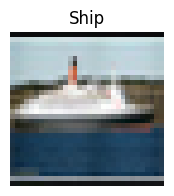

In [3]:
plt.figure(figsize=(2,2))
idx = np.random.randint(0,len(X_train))
img = image.array_to_img(X_train[idx], scale=True)
plt.imshow(img)
plt.axis('off')
plt.title(tags[y_train[idx][0]])
plt.show()

# Step 4: Defining Loss Functions and Optimizers
In the next step we need to define the Loss function and optimizer for the discriminator and generator networks in a Conditional Generative Adversarial Network(CGANS).
- Use Binary Cross-Entropy Loss for both generator and discriminator
- Define discriminator loss as sum of real and fake losses
- The binary entropy calculates two losses: 
    - `real_loss`: Loss when the discriminator tries to classify real data as real 
    - `fake_loss`: Loss when the discriminator tries to classify fake data as fake
- `d_optimizer` and `g_optimizer` are used to update the trainable parameters of the discriminator and generator during training
- Use Adam optimizer for both networks

In [4]:
bce_loss = tf.keras.losses.BinaryCrossentropy()

def discriminator_loss(real, fake):
    real_loss = bce_loss(tf.ones_like(real), real)
    fake_loss = bce_loss(tf.zeros_like(fake), fake)
    total_loss = real_loss + fake_loss
    return total_loss
  
def generator_loss(preds):
    return bce_loss(tf.ones_like(preds), preds)
  
d_optimizer=Adam(learning_rate=0.0002, beta_1 = 0.5)
g_optimizer=Adam(learning_rate=0.0002, beta_1 = 0.5)

# Step 5: Building the Generator Model
- Input: noise vector (latent space) and label
- Convert label to a vector using an embedding layer (size 50)
- Process noise through dense layers with `LeakyReLU` activation
- Reshape and concatenate label embedding with noise features
- Use `Conv2DTranspose` layers to up-sample into 32×32×3 images
- Output layer uses tanh activation to scale pixels between -1 and 1

In [5]:
def build_generator():
    in_label = tf.keras.layers.Input(shape=(1,))
    li = tf.keras.layers.Embedding(n_class, 50)(in_label)

    n_nodes = 8 * 8
    li = tf.keras.layers.Dense(n_nodes)(li)
    li = tf.keras.layers.Reshape((8, 8, 1))(li)
    in_lat = tf.keras.layers.Input(shape=(noise_dim,))

    n_nodes = 128 * 8 * 8
    gen = tf.keras.layers.Dense(n_nodes)(in_lat)
    gen = tf.keras.layers.LeakyReLU(alpha=0.2)(gen)
    gen = tf.keras.layers.Reshape((8, 8, 128))(gen)
    merge = tf.keras.layers.Concatenate()([gen, li])

    gen = tf.keras.layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same')(merge)  
    gen = tf.keras.layers.LeakyReLU(alpha=0.2)(gen)
    gen = tf.keras.layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same')(gen)  
    gen = tf.keras.layers.LeakyReLU(alpha=0.2)(gen)
    out_layer = tf.keras.layers.Conv2D(3, (8, 8), activation='tanh', padding='same')(gen)  

    model = Model([in_lat, in_label], out_layer)
    return model

g_model = build_generator()
g_model.summary()

/Users/tomcuel/.venvs/global_env/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 8192)      │    827,392 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 1, 50)     │        500 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 8192)      │          0 │ dense_1[0][0]     │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1, 64)     │      3,264 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 8, 8, 128) │          0 │ leaky_re_lu[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 8, 8, 1)   │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 8, 8, 129) │          0 │ reshape_1[0][0],  │
│ (Concatenate)       │                   │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 16, 16,    │    264,320 │ concatenate[0][0] │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 16, 16,    │          0 │ conv2d_transpose… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 32, 32,    │    262,272 │ leaky_re_lu_1[0]… │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 32, 32,    │          0 │ conv2d_transpose… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 32, 32, 3) │     24,579 │ leaky_re_lu_2[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,382,327 (5.27 MB)

 Trainable params: 1,382,327 (5.27 MB)

 Non-trainable params: 0 (0.00 B)

# Step 6: Building the Discriminator Model
- Input is our image and label
- Embed label into a 50-dimensional vector
- Reshape and concatenate label embedding with the input image
- Apply two `Conv2D` layers with `LeakyReLU` activations to extract features
- Flatten features, apply dropout to prevent overfitting
- Final dense layer with sigmoid activation outputs probability of real or fake

In [6]:
def build_discriminator():
  in_label = tf.keras.layers.Input(shape=(1,))
  li = tf.keras.layers.Embedding(n_class, 50)(in_label)
  
  n_nodes = img_size * img_size 
  li = tf.keras.layers.Dense(n_nodes)(li) 
  li = tf.keras.layers.Reshape((img_size, img_size, 1))(li) 
  in_image = tf.keras.layers.Input(shape=(img_size, img_size, 3)) 
  merge = tf.keras.layers.Concatenate()([in_image, li]) 

  fe = tf.keras.layers.Conv2D(128, (3,3), strides=(2,2), padding='same')(merge) 
  fe = tf.keras.layers.LeakyReLU(alpha=0.2)(fe)
  fe = tf.keras.layers.Conv2D(128, (3,3), strides=(2,2), padding='same')(fe) 
  fe = tf.keras.layers.LeakyReLU(alpha=0.2)(fe)
  
  fe = tf.keras.layers.Flatten()(fe) 
  fe = tf.keras.layers.Dropout(0.4)(fe)
  out_layer = tf.keras.layers.Dense(1, activation='sigmoid')(fe)

  model = Model([in_image, in_label], out_layer)
      
  return model

d_model = build_discriminator()
d_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 1, 50)     │        500 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1, 1024)   │     52,224 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 32, 32, 1) │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 32, 32, 4) │          0 │ input_layer_3[0]… │
│ (Concatenate)       │                   │            │ reshape_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 16, 16,    │      4,736 │ concatenate_1[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 16, 16,    │          0 │ conv2d_1[0][0]    │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 8, 8, 128) │    147,584 │ leaky_re_lu_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_4       │ (None, 8, 8, 128) │          0 │ conv2d_2[0][0]    │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 8192)      │          0 │ leaky_re_lu_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 8192)      │          0 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │      8,193 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 213,237 (832.96 KB)

 Trainable params: 213,237 (832.96 KB)

 Non-trainable params: 0 (0.00 B)

# Step 7: Creating Training Step Function
- Use TensorFlow’s Gradient Tape to calculate and apply gradients for both networks
- Alternate training discriminator on real and fake data
- Train generator to fool discriminator
- Use `@tf.function` for efficient graph execution

In [ ]:
@tf.function
def train_step(dataset):
    real_images, real_labels = dataset
 
    random_latent_vectors = tf.random.normal(shape=(batch_size, noise_dim))
    generated_images = g_model([random_latent_vectors, real_labels])
    with tf.GradientTape() as tape:
        pred_fake = d_model([generated_images, real_labels])
        pred_real = d_model([real_images, real_labels])
        d_loss = discriminator_loss(pred_real, pred_fake)
      
    grads = tape.gradient(d_loss, d_model.trainable_variables)
    d_optimizer.apply_gradients(zip(grads, d_model.trainable_variables))
   
    random_latent_vectors = tf.random.normal(shape=(batch_size, noise_dim))
    with tf.GradientTape() as tape:
        fake_images = g_model([random_latent_vectors, real_labels])
        predictions = d_model([fake_images, real_labels])
        g_loss = generator_loss(predictions)
    
    grads = tape.gradient(g_loss, g_model.trainable_variables)
    g_optimizer.apply_gradients(zip(grads, g_model.trainable_variables))
    
    return d_loss, g_loss

# Step 8: Visualizing Generated Images
- After each epoch we will generate images conditioned on different labels
- Display or save generated images to monitor training progress

In [8]:
def show_samples(num_samples, n_class, g_model):
    fig, axes = plt.subplots(10,num_samples, figsize=(10,20)) 
    fig.tight_layout()
    fig.subplots_adjust(wspace=None, hspace=0.2)

    for l in np.arange(10):
      random_noise = tf.random.normal(shape=(num_samples, noise_dim))
      label = tf.ones(num_samples)*l
      gen_imgs = g_model.predict([random_noise, label])
      for j in range(gen_imgs.shape[0]):
        img = image.array_to_img(gen_imgs[j], scale=True)
        axes[l,j].imshow(img)
        axes[l,j].yaxis.set_ticks([])
        axes[l,j].xaxis.set_ticks([])

        if j ==0:
          axes[l,j].set_ylabel(tags[l])
    plt.show()

# Step 9: Train the Model
- At the final step we will start training the model for specified epochs
- Print losses regularly to monitor performance
- Longer training typically results in higher quality images

Epoch:  0


100%|██████████| 3125/3125 [04:24<00:00, 11.80it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 890ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


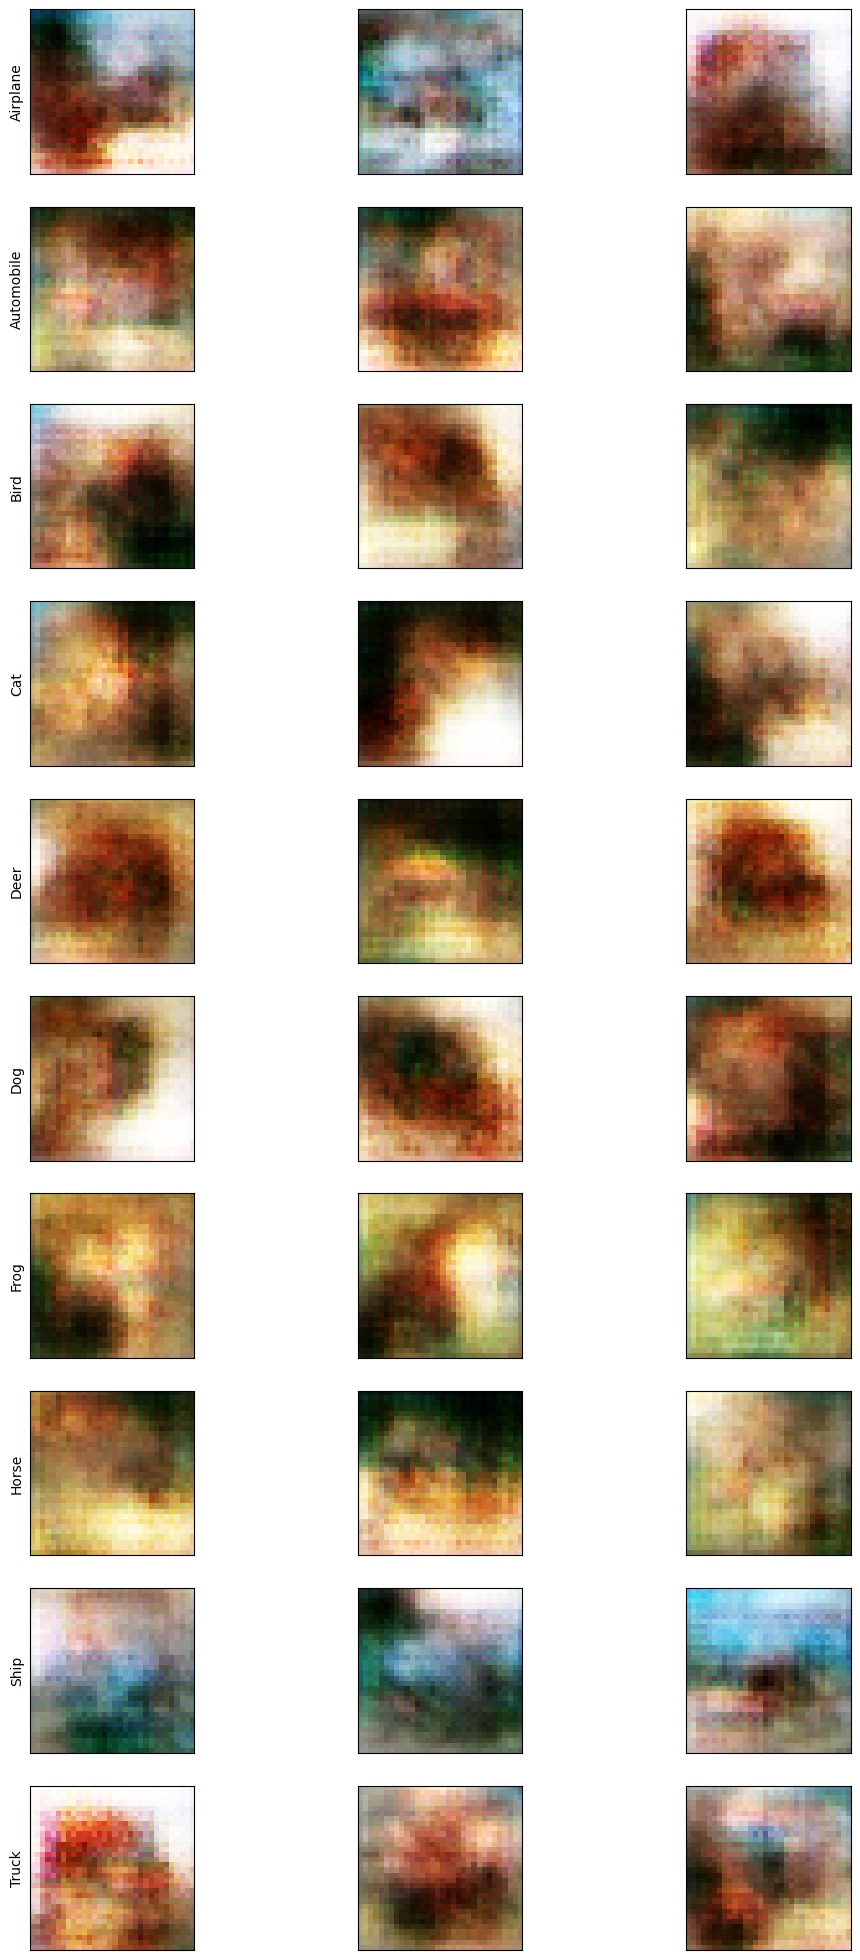

Epoch: 0 -- Generator Loss: 0.8364781737327576, Discriminator Loss: 1.3271902799606323

Took 270.91544580459595 seconds. 


Epoch:  1


100%|██████████| 3125/3125 [06:02<00:00,  8.62it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


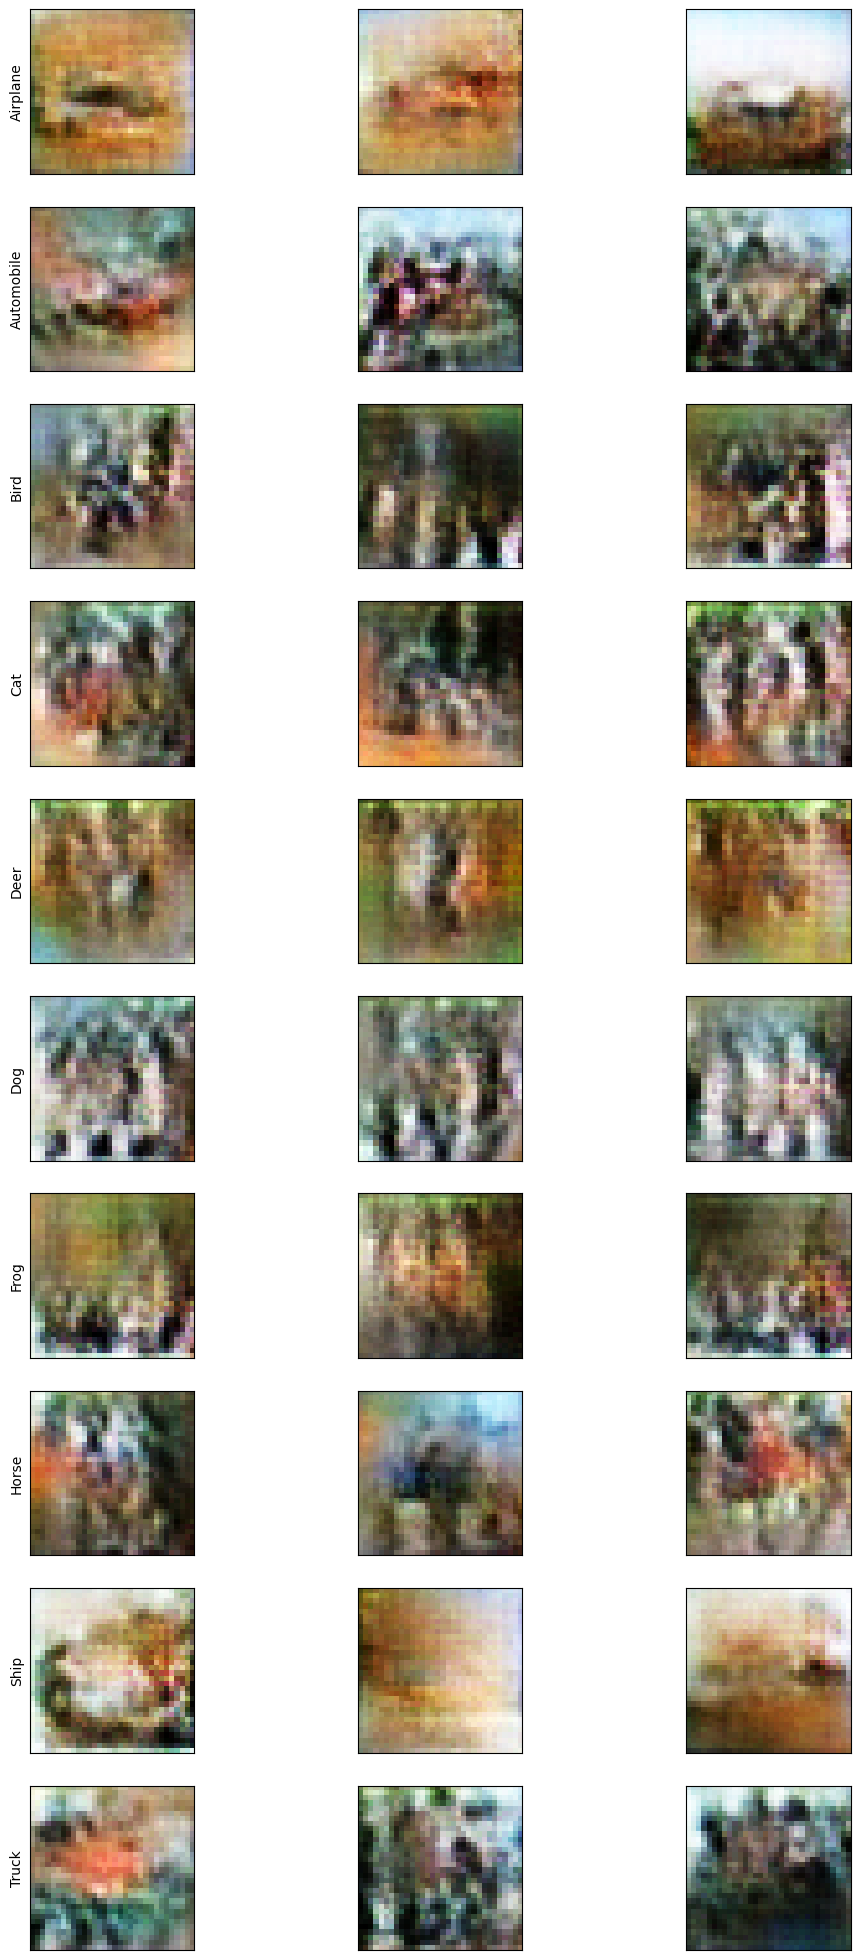

Epoch: 1 -- Generator Loss: 0.8200603127479553, Discriminator Loss: 1.3239364624023438

Took 366.27670788764954 seconds. 


Epoch:  2


100%|██████████| 3125/3125 [05:11<00:00, 10.04it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


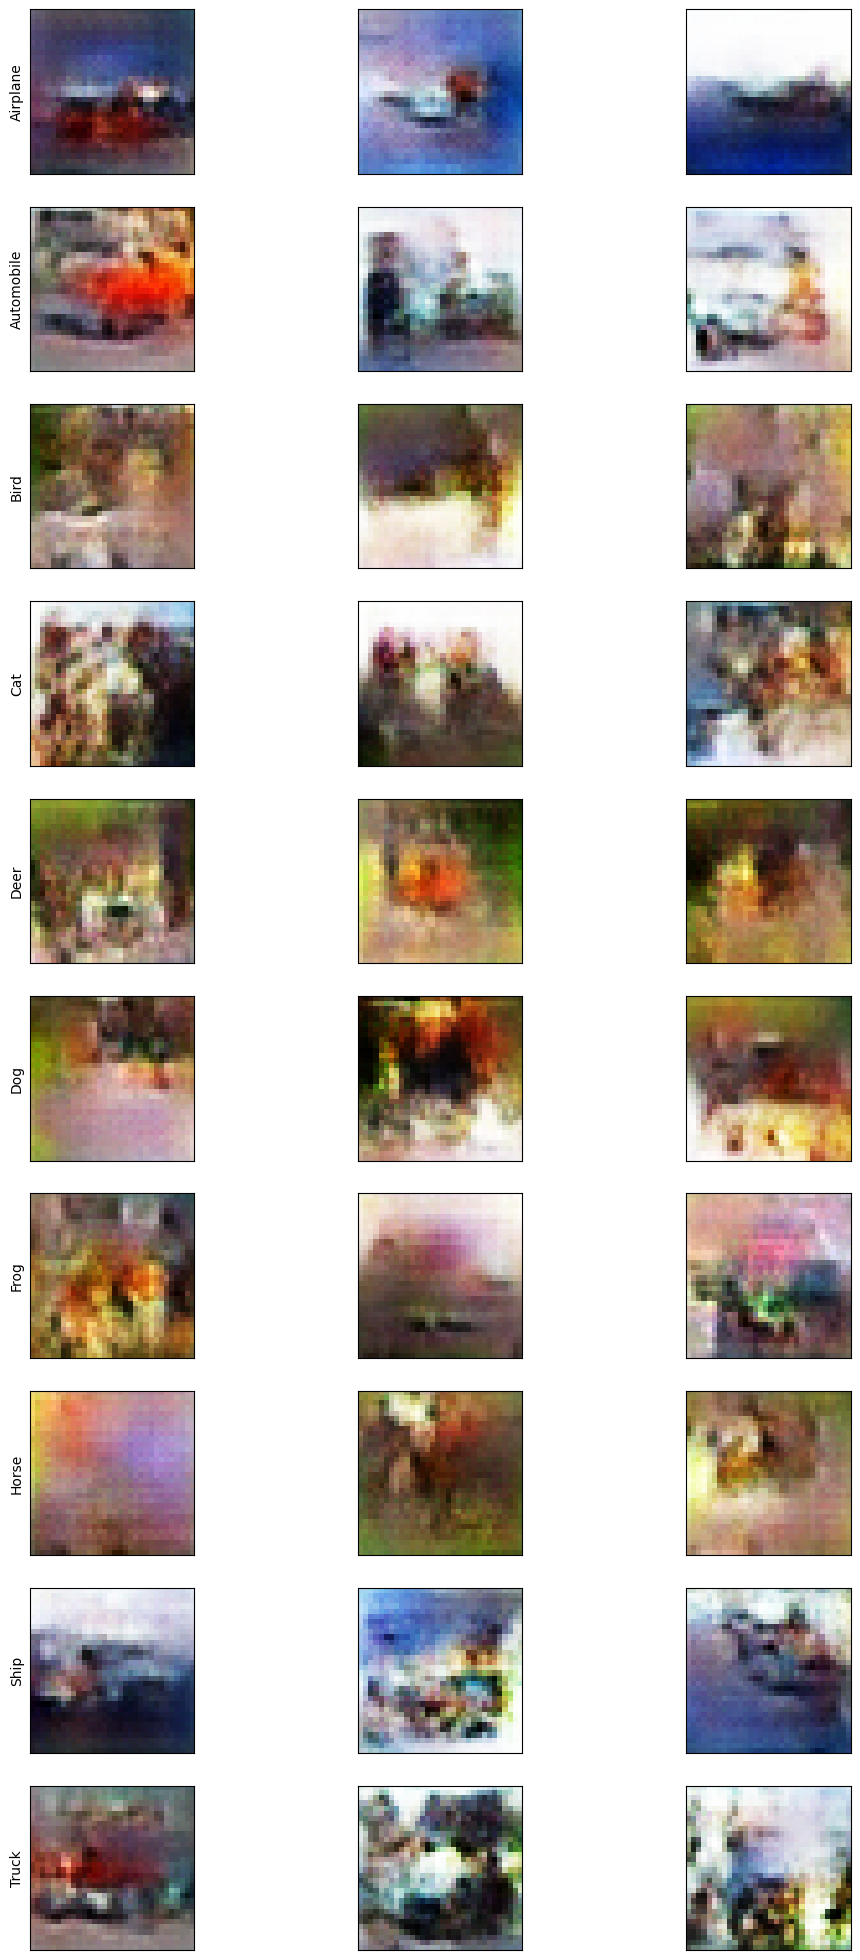

Epoch: 2 -- Generator Loss: 0.7898582816123962, Discriminator Loss: 1.3404567241668701

Took 315.2922360897064 seconds. 


Epoch:  3


  4%|▍         | 125/3125 [00:10<04:10, 11.96it/s]


KeyboardInterrupt: 

In [10]:
def train(dataset, epochs=epoch_count):

    for epoch in range(epochs):
        print('Epoch: ', epoch)
        d_loss_list = []
        g_loss_list = []
        start = time.time()
        
        itern = 0
        for image_batch in tqdm(dataset):
            d_loss, g_loss = train_step(image_batch)
            d_loss_list.append(d_loss)
            g_loss_list.append(g_loss)
            itern=itern+1
                
        show_samples(3, n_class, g_model)
        print (f'Epoch: {epoch} -- Generator Loss: {np.mean(g_loss_list)}, Discriminator Loss: {np.mean(d_loss_list)}\n')
        print (f'Took {time.time()-start} seconds. \n\n')
        
 
train(dataset, epochs=epoch_count)

We can see some details in these pictures. But for better result we need to run this for more epochs.